# Working with Text

**Prerequisites**

- [Visualization Rules](visualization_rules.ipynb)  
- [Regression](regression.ipynb)  
- Classification  
- [Maps](maps.ipynb)  


**Outcomes**

- Use text as features for classification  
- Understand latent topic analysis  
- Use folium to create an interactive map  
- Request and combine json data from a webserver  

## Introduction

Many data sources contain text as well as numerical data.

Text can be used to create features for any of the prediction methods
that we have discussed.

Doing so requires encoding text into some numerical representation.

A good encoding preserves the meaning in the original text, while
keeping dimensionality manageable.

In this lecture, we will learn how to work with text through an
application — predicting avalanche fatalities from avalanche
forecasts.

## Avalanches

Snow avalanches are a hazard in the mountains. Avalanches can be
partially predicted based on snow conditions, weather, and
terrain. [Avalanche Canada](https://www.avalanche.ca/map) produces
daily avalanche forecasts for various mountainous regions in
Canada. These forecasts consist of 1-5 ratings for each of three
elevation bands, and textual descriptions of the recent avalanche
observations, the snowpack, and weather. Avalanche Canada also
maintains a list of [fatal avalanche incidents](https://www.avalanche.ca/incidents/) . In this lecture, we will
attempt to predict fatal incidents from the text of avalanche
forecasts. Since fatal incidents are rare, this prediction task will
be quite difficult.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
plt.style.use('tableau-colorblind10')
#plt.style.use('Solarize_Light2')
#plt.style.use('bmh')

### Data

Avalanche Canada has an unstable json api. The api seems to be largely
tailored to displaying the information on various Avalanche Canada
websites and does not make it easy to obtain large amounts of
data. Nonetheless, it is easier to get information from the API than
to scrape the website. Generally, anytime you’re considering scraping
a website, you should check whether the site has an API that you could
use instead.

#### Incident Data

In [2]:
# Get data on avalanche forecasts and incidents from Avalanche Canada
# Avalanche Canada has an unstable public api
# https://github.com/avalanche-canada/ac-web
# Since API might change, this code might break
import json
import os
import urllib.request
import pandas as pd
import time

# Incidents
url = "http://incidents.avalanche.ca/public/incidents/?format=json"
req = urllib.request.Request(url)
with urllib.request.urlopen(req) as response:
    result = json.loads(response.read().decode('utf-8'))
incident_list = result["results"]
while (result["next"] != None) :
    req = urllib.request.Request(result["next"])
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    incident_list = incident_list + result["results"]
incidents_brief = pd.DataFrame.from_dict(incident_list,orient="columns")
incidents_brief

date        group_activity                                    id  \
0    2019-03-16           Ski touring  37d909e4-c6de-43f1-8416-57a34cd48255   
1    2019-03-11          Ice Climbing  53263a93-e674-4eda-999d-01e05fcf64ef   
2    2019-02-18           Snowshoeing  b3e31dcb-77d2-42b3-8115-e88a16b2f946   
3    2019-02-09          Snowmobiling  2a3afb33-ff26-48ab-b7ca-cfd840d203fa   
4    2019-01-26          Snowmobiling  87affdea-021e-4b13-b7fb-f52fa3b1437a   
5    2019-01-12          Snowmobiling  9413994e-a20d-4f52-8e84-dfc4ee6217b5   
6    2019-01-03                Skiing  3891fd51-8736-4373-9829-9159b950992b   
7    2018-03-28            Heliskiing  5930994f-0066-4e58-822e-15caf064c12e   
8    2018-02-10          Snowmobiling  533be18d-8019-42b1-9811-8509ca14106f   
9    2018-02-09          Snowmobiling  f1f2bfec-bd7b-4063-b46e-46aa213a8678   
10   2018-01-30          Snowmobiling  62ada927-3b2f-44a7-b765-4372c3886145   
11   2018-01-08    Backcountry Skiing  22b949ed-a192-4b28-82d9-760369d617e6   
12   2018-01-05          Snowmobiling  455adfa2-0ef6-4c41-b01a-2af0226aa494   
13   2017-12-31    Backcountry Skiing  e9a90226-1774-47f0-8ac7-acafe5eabcde   
14   2017-04-08  Snowshoeing & Hiking  6aa34cf6-fd76-4c4e-8db0-b89864d7b245   
15   2017-03-12  Snowshoeing & Hiking  181f837b-88a2-45d5-8806-e5225ccf8afe   
16   2017-03-06     Mechanized Skiing  6f5503dc-db49-4ed9-830e-855ae37fd55f   
17   2017-03-04    Backcountry Skiing  3880da2c-4404-4be3-b30d-bc130c9220d9   
18   2017-01-26                  Work  25ae1cb7-d05d-4f37-80a5-d25d2ac4ec28   
19   2017-01-21    Backcountry Skiing  02e20779-5ec5-402c-b463-79f5c37e96c3   
20   2016-12-30          Snowmobiling  92402335-894f-4998-b1d0-3ab5e7049011   
21   2016-09-25    Backcountry Skiing  0169d024-fa0b-4076-8064-2e557c9fc305   
22   2016-05-23        Mountaineering  8295e9da-8b59-47ff-a473-cae0fd8d3883   
23   2016-04-20    Backcountry Skiing  c080e409-0151-404e-bfd6-b1db7c63a660   
24   2016-03-20  Snowshoeing & Hiking  5afb006a-1f7a-40da-82a5-868aa6baeb59   
25   2016-03-14          Snowmobiling  a5ea1871-d2fb-44e1-8300-d022e6a9c26d   
26   2016-03-14          Snowmobiling  60347304-201c-497d-a5ec-05c73129bf63   
27   2016-03-13          Snowmobiling  70c2366b-fb59-462a-9a7b-e26661bd62f6   
28   2016-03-06          Snowmobiling  f9bae623-2e13-47fd-a445-6153d2e0e1fb   
29   2016-02-21    Backcountry Skiing  dc4c173f-cdf2-4d02-ba56-968c54606108   
..          ...                   ...                                   ...   
439  1898-02-22       Inside Building  257bc41b-53cb-49d0-932e-a32902333927   
440  1895-01-23               Unknown  a91a1570-2d8c-4eb1-93aa-45dd470ca7cf   
441  1893-03-12               Unknown  4caa4646-457d-4430-bb8d-25acc47326ca   
442  1891-01-20       Inside Building  172dcea1-d920-47ab-87b9-e4a197e6a1a7   
443  1891-01-20       Inside Building  8f9a7e1f-1cf1-41c4-a7c5-d726974db1ec   
444  1890-02-15               Unknown  07d90fbf-3948-4aa0-a998-961f05616556   
445  1885-02-25   At Outdoor Worksite  82a133d6-32cf-4b25-8cad-b0f43349fb89   
446  1885-02-08   At Outdoor Worksite  e6c62007-0b13-41f3-a7b0-cdc45f2936df   
447  1884-01-26   At Outdoor Worksite  db7c8176-4cd9-40bf-a43a-39c0f01bae81   
448  1879-02-12    Other Recreational  ec3779ef-d8c3-40c9-8ab5-e633534496c7   
449  1877-02-09       Inside Building  7aa144d1-cfd1-42ee-b365-28a05b301b1f   
450  1876-02-25               Unknown  8a3cf819-d3d0-465b-b194-ad99d9fca341   
451  1875-02-03       Inside Building  45b60b4c-c0b3-4853-a4d8-a3667a6efd4b   
452  1873-01-06               Unknown  cca580b8-01b7-43b1-85c6-7592f8b4fa65   
453  1869-03-11       Inside Building  b4d997c6-70e7-479e-a580-78c2b1d718d0   
454  1869-02-16       Inside Building  4e889b7b-b0c4-43a3-a2c4-a20fb5b24555   
455  1866-02-26       Inside Building  90e8a150-4bf0-4070-ba20-2ff775e82772   
456  1865-03-11               Unknown  3ed9e925-2de7-4b59-956f-16aea06af56c   
457  1863-03-12       Hunting/Fishing  426b79b1-3b68-4967-9e9

In [3]:
# We can get more information about these incidents e.g. "https://www.avalanche.ca/incidents/37d909e4-c6de-43f1-8416-57a34cd48255"
# this information is also available through the API
def get_incident_details(id) :
    url = "http://incidents.avalanche.ca/public/incidents/{}?format=json".format(id)
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    return(result)


incidentsfile="avalanche_incidents.csv"

# To avoid loading the avalanche canada servers, we save the incident details locally
if (not os.path.isfile(incidentsfile)) :
    incident_detail_list = incidents_brief.id.apply(get_incident_details).to_list()
    incidents = pd.DataFrame.from_dict(incident_detail_list,orient="columns")
    incidents.to_csv(incidentsfile)
else :
    incidents = pd.read_csv(incidentsfile)

incidents

Unnamed: 0  Unnamed: 0.1  \
0             0             0   
1             1             1   
2             2             2   
3             3             3   
4             4             4   
5             5             5   
6             6             6   
7             7             7   
8             8             8   
9             9             9   
10           10            10   
11           11            11   
12           12            12   
13           13            13   
14           14            14   
15           15            15   
16           16            16   
17           17            17   
18           18            18   
19           19            19   
20           20            20   
21           21            21   
22           22            22   
23           23            23   
24           24            24   
25           25            25   
26           26            26   
27           27            27   
28           28            28   
29           29            29   
..          ...           ...   
439         439           439   
440         440           440   
441         441           441   
442         442           442   
443         443           443   
444         444           444   
445         445           445   
446         446           446   
447         447           447   
448         448           448   
449         449           449   
450         450           450   
451         451           451   
452         452           452   
453         453           453   
454         454           454   
455         455           455   
456         456           456   
457         457           457   
458         458           458   
459         459           459   
460         460           460   
461         461           461   
462         462           462   
463         463           463   
464         464           464   
465         465           465   
466         466           466   
467         467           467   
468         468           468   

                                         avalanche_obs  \
0    [{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...   
1    [{'size': '2.5', 'type': 'S', 'trigger': 'Na',...   
2    [{'size': '2.5', 'type': 'S', 'trigger': 'Sa',...   
3    [{'size': '2.0', 'type': 'S', 'trigger': 'Ma',...   
4    [{'size': '2.0', 'type': 'CS', 'trigger': 'Nc'...   
5    [{'size': '3.0', 'type': 'S', 'trigger': 'Ma',...   
6    [{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...   
7    [{'size': '3.0', 'type': 'S', 'trigger': 'Sa',...   
8    [{'size': '2.0', 'type': 'CS', 'trigger': 'Ma'...   
9    [{'size': '2.0', 'type': 'S', 'trigger': 'Ma',...   
10                                                  []   
11   [{'observation_date': '2018-01-08 15:00', 'siz...   
12   [{'observation_date': '2018-01-05 12:00', 'siz...   
13   [{'observation_date': '2017-12-31 12:00', 'siz...   
14   [{'observation_date': '2017-04-08 15:43', 'siz...   
15   [{'observation_date': '2017-03-12 00:00', 'siz...   
16   [{'observation_date': '2017-03-08 10:59', 'siz...   
17   [{'observation_date': '2017-03-04 11:39', 'siz...   
18                                                  []   
19   [{'observation_date': '2017-01-21 09:00', 'siz...   
20   [{'observation_date': '2016-12-30 13:45', 'siz...   
21   [{'observation_date': '2016-09-25 09:00', 'siz...   
22   [{'observation_date': '2016-05-23 00:00', 'siz...   
23   [{'observation_date': '2016-04-20 10:30', 'siz...   
24   [{'observation_date': '2016-03-20 00:00', 'siz...   
25   [{'observation_date': '2016-03-14 00:00', 'siz...   
26   [{'observation_date': '2016-03-14 15:00', 'siz...   
27   [{'observation_date': '2016-03-13 00:00', 'siz...   
28   [{'observation_date': '2016-03-06 00:00', 'siz...   
29   [{'observation_date': '2016-02-21 11:00', 'siz...   
..                                                 ...   
439  [{'observation_date': '1898-02-22', 'size': ''...   
440                                         

Many of the incidents include coordinates, but others do not. Most
however, include a place name. We can use [Natural Resources Canada’s
Geolocation Service](https://www.nrcan.gc.ca/earth-sciences/geography/topographic-information/geolocalisation-service/17304)
to retrieve coordinates from place names.

In [4]:
# geocode locations without coordinates
def geolocate(location,province) :
    url = "http://geogratis.gc.ca/services/geolocation/en/locate?q={},%20{}".format(urllib.parse.quote(location),province)
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    if (len(result)==0) :
        return([None,None])
    else :
        return(result[0]['geometry']['coordinates'])
if not "alt_coord" in incidents.columns :
    incidents["alt_coord"] = [geolocate(incidents.location[i], incidents.location_province[i]) for i in incidents.index]
    incidents.to_csv(incidentsfile)

Now that we have incident data, let’s create some figures.

In [5]:
# clean up activity names
incidents.group_activity.unique()

array(['Ski touring', 'Ice Climbing', 'Snowshoeing', 'Snowmobiling',
       'Skiing', 'Heliskiing', 'Backcountry Skiing',
       'Snowshoeing & Hiking', 'Mechanized Skiing', 'Work',
       'Mountaineering', 'Other Recreational', 'Out-of-bounds Skiing',
       'At Outdoor Worksite', 'Lift Skiing Closed', 'Lift Skiing Open',
       'Hunting/Fishing', 'Out-of-Bounds Skiing', 'Control Work',
       'Inside Building', 'Car/Truck on Road', 'Inside Car/Truck on Road',
       'Unknown', 'Outside Building'], dtype=object)

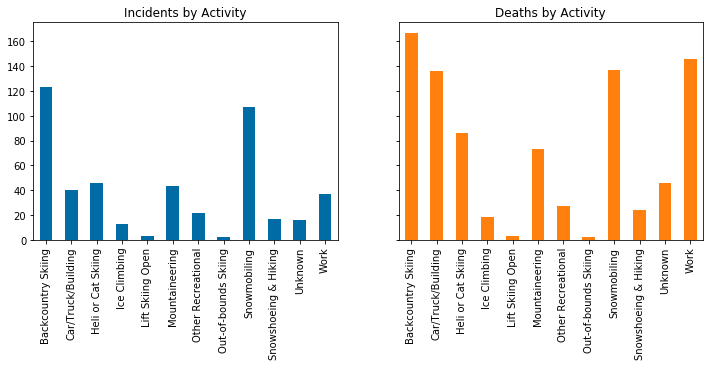

In [6]:
incidents.group_activity=incidents.group_activity.replace("Ski touring","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Out-of-Bounds Skiing","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Lift Skiing Closed","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Skiing","Backcountry Skiing")
incidents.group_activity=incidents.group_activity.replace("Snowshoeing","Snowshoeing & Hiking")
incidents.group_activity=incidents.group_activity.replace("Snowshoeing and Hiking","Snowshoeing & Hiking")
incidents.group_activity=incidents.group_activity.replace("Mechanized Skiing","Heli or Cat Skiing")
incidents.group_activity=incidents.group_activity.replace("Heliskiing","Heli or Cat Skiing")
incidents.group_activity=incidents.group_activity.replace("At Outdoor Worksite","Work")
incidents.group_activity=incidents.group_activity.replace("Control Work","Work")
incidents.group_activity=incidents.group_activity.replace("Hunting/Fishing","Other Recreational")
incidents.group_activity=incidents.group_activity.replace("Inside Car/Truck on Road","Car/Truck/Building")
incidents.group_activity=incidents.group_activity.replace("Car/Truck on Road","Car/Truck/Building")
incidents.group_activity=incidents.group_activity.replace("Inside Building","Car/Truck/Building")
incidents.group_activity=incidents.group_activity.replace("Outside Building","Car/Truck/Building")


incidents.group_activity.unique()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))
colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
incidents.groupby(['group_activity']).id.count().plot(kind='bar', title="Incidents by Activity", ax=ax[0])
incidents.groupby(['group_activity']).num_fatal.sum().plot(kind='bar', title="Deaths by Activity", ax=ax[1], color=colors[1])
ax[0].set_xlabel(None)
ax[1].set_xlabel(None);

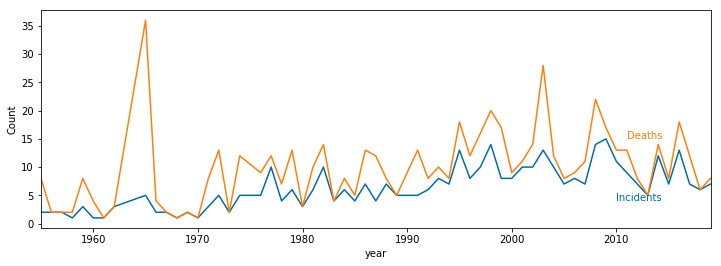

In [7]:
incidents["date"] = pd.to_datetime(incidents.ob_date)
incidents["year"] = incidents.date.apply(lambda x: x.year)
incidents.date = incidents.date.dt.date
colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
f = incidents.groupby(["year"]).num_fatal.sum()
n = incidents.groupby(["year"]).id.count()
yearstart=1950
f=f[f.index>yearstart]
n=n[n.index>yearstart]
fig,ax = plt.subplots(1,1,figsize=(12,4))
n.plot(ax=ax)
f.plot(ax=ax)
ax.set_ylabel("Count")
ax.annotate("Incidents", (2010, 4), color=colors[0])
ax.annotate("Deaths", (2011, 15), color=colors[1]);

#### Mapping Incidents

Since the incident data includes coordinates, we might as well make a
map too. Unfortunately, there are some obvious errors in some of the
latitude and longitudes. Here, we try to fix the errors.

In [8]:
import re

# fix errors in latitude, longitude
latlon = incidents.location_coords
def makenumeric(cstr) :
    if cstr==None :
        return([None,None])
    elif (type(cstr)==str):
        return([float(s) for s in re.findall(r'-?\d+\.?\d*',cstr)])
    else :
        return(cstr)

latlon = latlon.apply(makenumeric)

def good_lat(lat) :
    return(lat >= 41.6 and lat <= 83.12) # min & max for Canada
def good_lon(lon) :
    return(lon >= -141 and lon<= -52.6)
def fixlatlon(c) :
    if (len(c)<2 or type(c[0])!=float or type(c[1])!=float) :
        c = [None, None]
        return(c)
    lat = c[0]
    lon = c[1]
    if not good_lat(lat) and good_lat(lon) :
        tmp = lat
        lat = lon
        lon = tmp
    if not good_lon(lon) and good_lon(-lon) :
        lon = -lon
    if not good_lon(lon) and good_lon(lat) :
        tmp = lat
        lat = lon
        lon = tmp
    if not good_lon(lon) and good_lon(-lat) :
        tmp = -lat
        lat = lon
        lon = tmp
    if not good_lat(lat) or not good_lon(lon) :
        c[0] = None
        c[1] = None
    else :
        c[0] = lat
        c[1] = lon
    return(c)

incidents["latlon"] = latlon.apply(fixlatlon)

In [9]:
def foo(c,a) :
    if (type(a)==str) :
        a = [float(s) for s in re.findall(r'-?\d+\.?\d*',a)]
    if len(a) <2 :
        a = [None,None]
    return([a[1],a[0]] if type(c[0])!=float else c)
incidents["latlon_filled"]=[foo(c,a) for c,a in zip(incidents["latlon"],incidents["alt_coord"])]
nmiss = sum([a[0]==None for a in incidents.latlon_filled])
n = len(incidents.latlon_filled)
print("{} of {} incidents have latitude & longitude".format(n-nmiss, n))

308 of 469 incidents have latitude & longitude


In [10]:
# download forecast region definitions
req = urllib.request.Request("https://www.avalanche.ca/api/forecasts")
with urllib.request.urlopen(req) as response:
    forecastregions = json.loads(response.read().decode('utf-8'))

You may have to uncomment the second line below if  folium is not installed.

In [11]:
# Map forecast regions and incidents
#!pip install --user folium
import folium
import matplotlib

cmap = matplotlib.cm.get_cmap('Set1')
fmap = folium.Map(location=[60, -98],
                            zoom_start=3,
                            tiles='Stamen Terrain')
folium.GeoJson(forecastregions,
               tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=[""]),
               highlight_function=lambda x: { 'weight': 10},
              style_function=lambda x: {'weight':1}).add_to(fmap)
activities = incidents.group_activity.unique()
for i in incidents.index :
    if not None==incidents.latlon_filled[i][0] and not None==incidents.latlon_filled[i][1] :
        cindex=[j for j,x in enumerate(activities) if x==incidents.group_activity[i]][0]
        txt = "{}, {}<br>{} deaths"
        txt = txt.format(incidents.group_activity[i],
                        incidents.ob_date[i],
                        incidents.num_fatal[i]
                        )
        pop = folium.Popup(incidents.comment[i], parse_html=True, max_width=400)
        folium.CircleMarker(incidents.latlon_filled[i],
                      tooltip=txt,
                      popup=pop,
                      color=matplotlib.colors.to_hex(cmap(cindex)), fill=True, radius=5).add_to(fmap)
fmap

Take a moment to click around the map and read about some of the incidents.

Compare presenting this information on a map with the list on [https://www.avalanche.ca/incidents/](https://www.avalanche.ca/incidents/) .
Which do you prefer and why?

#### Matching Incidents to Regions

Later we will want to match incidents to forecasts, so let’s find the closest region to each incident.

Note that distance here will be in units of latitude, longitude (or
whatever coordinate system we use). At the equator, a distance of 1 is
approximately 60 nautical miles.

Since longitude lines get closer together farther from the equator,
these distances will be understated the further North you go.

I do not think this is too much of a problem for just finding the
nearest region, but if we care about accurate distances, we should
reproject latitude and longitude into a different coordinate system.

In [12]:
# Match incidents to nearest forecast regions
from shapely.geometry import Point, Polygon, shape
point = Point(incidents.latlon_filled[0][1],incidents.latlon_filled[0][0])
def distances(latlon) :
    point=Point(latlon[1],latlon[0])
    df = pd.DataFrame.from_dict([{'id':feature['id'],
                                  'distance':shape(feature['geometry']).distance(point)} for
                                 feature in forecastregions['features']])
    return(df)
def foo(x) :
    if (x[0]==None) :
        return(None)
    d = distances(x)
    return(d.id[d.distance.idxmin()])
incidents['nearest_region'] = incidents.latlon_filled.apply(foo)
incidents['nearest_distance'] = incidents.latlon_filled.apply(lambda x : None if x[0]==None else distances(x).distance.min())

In [13]:
incidents

Unnamed: 0  Unnamed: 0.1  \
0             0             0   
1             1             1   
2             2             2   
3             3             3   
4             4             4   
5             5             5   
6             6             6   
7             7             7   
8             8             8   
9             9             9   
10           10            10   
11           11            11   
12           12            12   
13           13            13   
14           14            14   
15           15            15   
16           16            16   
17           17            17   
18           18            18   
19           19            19   
20           20            20   
21           21            21   
22           22            22   
23           23            23   
24           24            24   
25           25            25   
26           26            26   
27           27            27   
28           28            28   
29           29            29   
..          ...           ...   
439         439           439   
440         440           440   
441         441           441   
442         442           442   
443         443           443   
444         444           444   
445         445           445   
446         446           446   
447         447           447   
448         448           448   
449         449           449   
450         450           450   
451         451           451   
452         452           452   
453         453           453   
454         454           454   
455         455           455   
456         456           456   
457         457           457   
458         458           458   
459         459           459   
460         460           460   
461         461           461   
462         462           462   
463         463           463   
464         464           464   
465         465           465   
466         466           466   
467         467           467   
468         468           468   

                                         avalanche_obs  \
0    [{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...   
1    [{'size': '2.5', 'type': 'S', 'trigger': 'Na',...   
2    [{'size': '2.5', 'type': 'S', 'trigger': 'Sa',...   
3    [{'size': '2.0', 'type': 'S', 'trigger': 'Ma',...   
4    [{'size': '2.0', 'type': 'CS', 'trigger': 'Nc'...   
5    [{'size': '3.0', 'type': 'S', 'trigger': 'Ma',...   
6    [{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...   
7    [{'size': '3.0', 'type': 'S', 'trigger': 'Sa',...   
8    [{'size': '2.0', 'type': 'CS', 'trigger': 'Ma'...   
9    [{'size': '2.0', 'type': 'S', 'trigger': 'Ma',...   
10                                                  []   
11   [{'observation_date': '2018-01-08 15:00', 'siz...   
12   [{'observation_date': '2018-01-05 12:00', 'siz...   
13   [{'observation_date': '2017-12-31 12:00', 'siz...   
14   [{'observation_date': '2017-04-08 15:43', 'siz...   
15   [{'observation_date': '2017-03-12 00:00', 'siz...   
16   [{'observation_date': '2017-03-08 10:59', 'siz...   
17   [{'observation_date': '2017-03-04 11:39', 'siz...   
18                                                  []   
19   [{'observation_date': '2017-01-21 09:00', 'siz...   
20   [{'observation_date': '2016-12-30 13:45', 'siz...   
21   [{'observation_date': '2016-09-25 09:00', 'siz...   
22   [{'observation_date': '2016-05-23 00:00', 'siz...   
23   [{'observation_date': '2016-04-20 10:30', 'siz...   
24   [{'observation_date': '2016-03-20 00:00', 'siz...   
25   [{'observation_date': '2016-03-14 00:00', 'siz...   
26   [{'observation_date': '2016-03-14 15:00', 'siz...   
27   [{'observation_date': '2016-03-13 00:00', 'siz...   
28   [{'observation_date': '2016-03-06 00:00', 'siz...   
29   [{'observation_date': '2016-02-21 11:00', 'siz...   
..                                                 ...   
439  [{'observation_date': '1898-02-22', 'size': ''...   
440                                         

#### Forecast Data

We now download all forecasts for all regions since November 2011 (roughly the earliest data available).

We can only request one forecast at a time, so this takes many hours to finish.

The forecasts are saved to disk and included in the github repository to avoid re-downloading.

In [14]:
# Functions for downloading forecasts from Avalanche Canada

def get_forecast(date, region) :
    url = "https://www.avalanche.ca/api/bulletin-archive/{}/{}.json".format(date.isoformat(),region)
    try:
        req = urllib.request.Request(url)
        with urllib.request.urlopen(req) as response:
            result = json.loads(response.read().decode('utf-8'))
        return(result)
    except:
        return(None)

def get_forecasts(start, end, region) :
    day = start
    forecasts = []
    while(day<=end and day<end.today()) :
        #print("working on {}, {}".format(region,day))
        forecasts = forecasts + [get_forecast(day, region)]
        #print("sleeping")
        time.sleep(0.1) # to avoid too much load on Avalanche Canada servers
        day = day + pd.Timedelta(1,"D")
    return(forecasts)

def get_season(year, region) :
    start_month = 11
    start_day = 20
    last_month = 5
    last_day = 1
    if (not os.path.isdir("avalanche_forecasts")):
        os.mkdir("avalanche_forecasts")
    seasonfile = "avalanche_forecasts/{}_{}-{}.json".format(region, year, year+1)
    if (not os.path.isfile(seasonfile)) :
        startdate = pd.to_datetime("{}-{}-{} 12:00".format(year, start_month, start_day))
        lastdate = pd.to_datetime("{}-{}-{} 12:00".format(year+1, last_month, last_day))
        season = get_forecasts(startdate,lastdate,region)
        with open(seasonfile, 'w') as outfile:
            json.dump(season, outfile, ensure_ascii=False)
    else :
        with open(seasonfile) as json_data:
            season = json.load(json_data)
    return(season)

In [15]:
forecastlist=[]

for year in range(2011,2019) :
    for region in [region["id"] for region in forecastregions["features"]] :
        print("working on {}, {}".format(region, year))
        forecastlist = forecastlist + get_season(year, region)

working on little-yoho, 2011
working on banff-yoho-kootenay, 2011
working on northwest-coastal, 2011
working on northwest-inland, 2011
working on sea-to-sky, 2011
working on south-coast-inland, 2011
working on south-coast, 2011
working on north-rockies, 2011
working on cariboos, 2011
working on north-columbia, 2011
working on south-columbia, 2011
working on purcells, 2011
working on kootenay-boundary, 2011
working on south-rockies, 2011
working on lizard-range, 2011
working on vancouver-island, 2011
working on jasper, 2011
working on kananaskis, 2011
working on waterton, 2011
working on chic-chocs, 2011
working on glacier, 2011
working on renshaw, 2011
working on kakwa, 2011
working on telkwa, 2011
working on hankin-evelyn, 2011
working on yukon, 2011
working on little-yoho, 2012
working on banff-yoho-kootenay, 2012
working on northwest-coastal, 2012
working on northwest-inland, 2012
working on sea-to-sky, 2012
working on south-coast-inland, 2012
working on south-coast, 2012
working on

In [16]:
# convert to dataframe and extract some variables
forecasts = pd.DataFrame.from_dict([f for f in forecastlist if not f==None],orient="columns")

forecasts["danger_date"] = forecasts.dangerRatings.apply(lambda r : r[0]["date"])
forecasts["danger_date"] = pd.to_datetime(forecasts.danger_date).dt.date
forecasts["danger_alpine"]=forecasts.dangerRatings.apply(lambda r : r[0]["dangerRating"]["alp"])
forecasts["danger_treeline"]=forecasts.dangerRatings.apply(lambda r : r[0]["dangerRating"]["tln"])
forecasts["danger_belowtree"]=forecasts.dangerRatings.apply(lambda r : r[0]["dangerRating"]["btl"])

In [17]:
forecasts.head()

avalancheSummary  \
0  We have a few reports of glide crack releases ...   
1   No new avalanches observed. We suspect that t...   
2   No recent avalanche have been reported, but I...   
3   No recent avalanche have been reported, but I...   
4   No recent avalanche have been reported, but I...   

                            bulletinTitle  \
0  Avalanche Forecast - Northwest Coastal   
1  Avalanche Forecast - Northwest Coastal   
2  Avalanche Forecast - Northwest Coastal   
3  Avalanche Forecast - Northwest Coastal   
4  Avalanche Forecast - Northwest Coastal   

                                          confidence dangerMode  \
0          Poor -  Due to limited field observations        NaN   
1  Poor -  Timing, track, or intensity of incomin...        NaN   
2  Fair -  Due to limited field observationsfor t...        NaN   
3  Poor -  Due to limited field observationsfor t...        NaN   
4  Poor -  Due to limited field observationsfor t...        NaN   

                                       dangerRatings  \
0  [{'date': '2011-11-21T00:49:00.000Z', 'dangerR...   
1  [{'date': '2011-11-22T01:00:00.000Z', 'dangerR...   
2  [{'date': '2011-11-23T01:43:00.000Z', 'dangerR...   
3  [{'date': '2011-11-24T01:38:00.000Z', 'dangerR...   
4  [{'date': '2011-11-25T00:55:00.000Z', 'dangerR...   

                 dateIssued forecaster  \
0  2011-11-20T00:49:00.000Z     triley   
1  2011-11-21T01:00:00.000Z     triley   
2  2011-11-22T01:43:00.000Z  ccampbell   
3  2011-11-23T01:38:00.000Z  ccampbell   
4  2011-11-24T00:55:00.000Z       User   

                                          highlights         id  \
0   This bulletin is based on limited data. Local...  bid_29924   
1   This bulletin is based on limited data. Local...  bid_29943   
2  This bulletin is based on limited data. Local ...  bid_29965   
3  This bulletin is based on limited data. Local ...  bid_30080   
4  Avalanche danger is expected to remain HIGH as...  bid_30358   

                                            problems             region  \
0  [{'type': 'Wind Slabs', 'likelihood': 'Likely ...  northwest-coastal   
1  [{'type': 'Wind Slabs', 'likelihood': 'Likely'...  northwest-coastal   
2  [{'type': 'Wind Slabs', 'likelihood': 'Very Li...  northwest-coastal   
3  [{'type': 'Wind Slabs', 'likelihood': 'Very Li...  northwest-coastal   
4  [{'type': 'Wind Slabs', 'likelihood': 'Very Li...  northwest-coastal   

                                     snowpackSummary  \
0  Total snowpack depth in most sheltered treelin...   
1  Varying temperature, precipitation intensity, ...   
2  As of Monday afternoon, recent storm snow tota...   
3  Recent storm snow totals are in the 30-60cm ra...   
4  Another 15cm last night keeps adding to the re...   

                 validUntil  \
0  2011-11-21T00:00:00.000Z   
1  2011-11-22T00:00:00.000Z   
2  2011-11-23T00:00:00.000Z   
3  2011-11-24T00:00:00.000Z   
4  2011-11-25T00:00:00.000Z   

                                     weatherForecast danger_date  \
0   Sunday should continue to be cooler and drier...  2011-11-21   
1   Moderate to heavy precipitation is forecast t...  2011-11-22   
2   Tuesday: Expect another 30-40cm, especially i...  2011-11-23   
3   Wednesday: 20-30cm of snow, primarily in the ...  2011-11-24   
4   Thursday: 20-30cm of snow with freezing level...  2011-11-25   

    danger_alpine danger_treeline danger_belowtree  
0      2:Moderate      2:Moderate            1:Low  
1  3:Considerable  3:Considerable       2:Moderate  
2          4:High          4:High   3:Considerable  
3          4:High          4:High   3:Considerable  
4          4:High          4:High   3:Considerable

In [18]:
# merge incidents to forecasts
adf = pd.merge(forecasts, incidents, how="left",
               left_on=["region","danger_date"],
               right_on=["nearest_region","date"],
              indicator=True)
adf["incident"] = adf._merge=="both"
print("There were {} incidents matched with forecasts data. These occured on {}% of day-regions with forecasts".format(adf.incident.sum(),adf.incident.mean()*100))

There were 39 incidents matched with forecasts data. These occured on 0.26666666666666666% of day-regions with forecasts


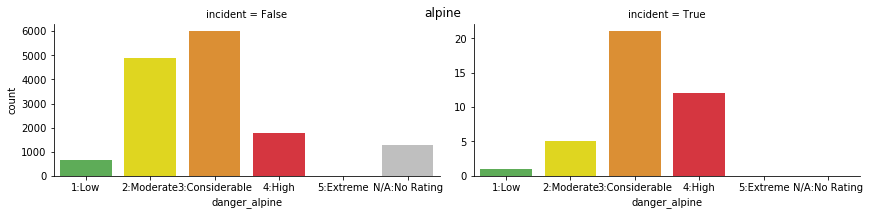

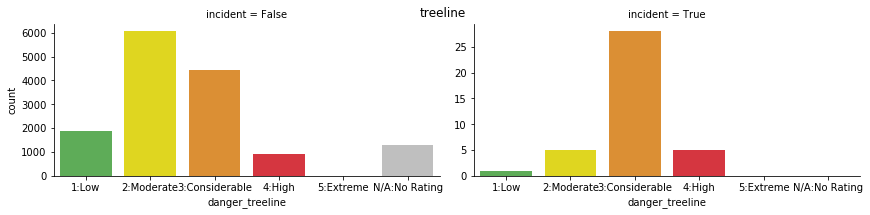

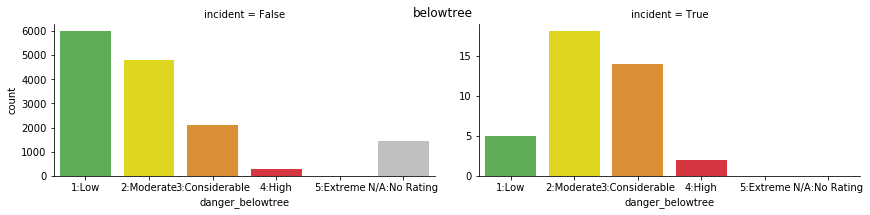

In [19]:
import seaborn as sns
ratings=sorted(adf.danger_alpine.unique())
ava_colors = ["#52BA4A", "#FFF300", "#F79218", "#EF1C29", "#1A1A1A", "#BFBFBF"]
for x in ["danger_alpine", "danger_treeline", "danger_belowtree"] :
    fig=sns.catplot(x=x, kind="count",col="incident", order=ratings, data=adf, sharey=False,
                    palette=ava_colors, height=3, aspect=2)
    plt.subplots_adjust(top=0.9)
    fig.fig.suptitle(x.replace("danger_",""))
    display(fig)

## Predicting Incidents from Text

### Preprocessing

The first step when using text as data is to preprocess the text.

In preprocessing we will :

1. Remove unwanted punctuation and non-text characters  
1. Tokenize: break down sentences into words  
1. Remove “stopwords”: words that are so common they provide no information, like “a” and “the”  
1. Lemmatize words : reduce words to their dictionary “lemma” e.g. “snowing” and “snowed” both become snow (verb)  

In [20]:
from bs4 import BeautifulSoup
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Remove stop words (the, a, is, etc)
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords=stopwords.union(set(string.punctuation))
# Lemmatize words e.g. snowed and snowing are both snow (verb)
wnl = nltk.WordNetLemmatizer()
def text_prep(txt) :
    soup = BeautifulSoup(txt)
    [s.extract() for s in soup('style')] # remove css
    txt=soup.text # remove html tags
    tokens = [token for token in nltk.tokenize.word_tokenize(txt)]
    tokens = [token for token in tokens if not token in stopwords]
    #tokens = [token for token in tokens if not token ]
    tokens = [wnl.lemmatize(token) for token in tokens]
    if (len(tokens)==0) :
        tokens = ["EMPTYSTRING"]
    return(tokens)

text_prep(forecasts.highlights[1000])

[nltk_data] Downloading package punkt to /home/paul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/paul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/paul/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['Avalanche',
 'danger',
 'could',
 'spike',
 'HIGH',
 'slope',
 'getting',
 'baked',
 'sun',
 'Avoid',
 'traveling',
 'underneath',
 'area']

Now let’s apply this to all the avalanche summaries.

In [21]:
text_data = [text_prep(txt) for txt in adf.avalancheSummary]

Let’s make a bar plot of the most common words.

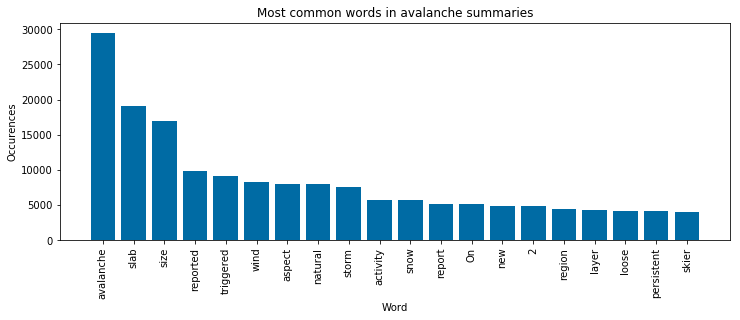

In [22]:
wf = nltk.FreqDist([word for doc in text_data for word in doc]).most_common(20)
words = [x[0] for x in wf]
cnt = [x[1] for x in wf]

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(range(len(words)), cnt);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Most common words in avalanche summaries');
ax.set_xlabel('Word');
ax.set_ylabel('Occurences');
plt.show()

### Feature Engineering

The simplest approach to convert a collection of processed text
documents to a feature matrix is the “bag of words” approach. We view
each document as a bag of words and our feature matrix consists of
counts of how many time each word appears. It’s called a bag of words
because we ignore the order of words within the documents.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
text_data = [text_prep(txt) for txt in adf.avalancheSummary]
y = adf.incident
X = vectorizer.fit_transform([' '.join(doc) for doc in text_data])

More complicated feature engineering is also possible. One extension
is to consider counts of pairs or triples of consecutive words. These
are called n-grams, and can be created by setting the n_gram
argument for CountVectorizer. Another alternative is to adjust for
the fact that common words will inherently have higher counts using
term-frequency inverse-document-frequency (see below).

Having created our feature matrix, we can now apply any classification
method to predict incidents.

### Naive Bayes Classifier

A type of classifier that is often used with text data is the Naive Bayes classifier.
This classifier predicts incidents using Bayes rules

$$
P(incident | words) = \frac{P(words|incident) P(incidents)}{P(words)}
$$

It is Naive in that it assumes words are independent of one another given an incident.

$$
P(words|incident) = \prod_{w \in words} P(w|incident)
$$

Although this assumption is very implausible for text, the Naive Bayes
classifier can be computed extremely quickly, and it sometimes performs well.

In [24]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=124)

In [25]:
from sklearn import naive_bayes
classifier = naive_bayes.MultinomialNB()
classifier.fit(Xtrain,ytrain)
np.mean(classifier.predict(Xtest)==ytest)

0.9936189608021878

In [26]:
from sklearn import metrics
print(metrics.confusion_matrix(ytest, classifier.predict(Xtest)))
print(metrics.classification_report(ytest, classifier.predict(Xtest)))

[[4358   18]
 [  10    2]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4376
        True       0.10      0.17      0.12        12

   micro avg       0.99      0.99      0.99      4388
   macro avg       0.55      0.58      0.56      4388
weighted avg       1.00      0.99      0.99      4388



In [27]:
# print text with highest predicted probabilities
phat=classifier.predict_proba(X)[:,1]
def remove_html(txt) :
    soup = BeautifulSoup(txt)
    [s.extract() for s in soup('style')] # remove css
    return(soup.text)
docs = [remove_html(txt) for txt in adf.avalancheSummary]
[(_,x) for _, x in sorted(zip(phat,docs), key=lambda pair: pair[0],reverse=True)]

[(0.9997811283128446,
  'On Friday avalanches ran naturally to size 2, while explosive control work produced avalanches up to size 2.5. Check out the Mountain Information Network for more details about a human triggered size 2 on a NW facing slope along the Bonnington Traverse. On Thursday reports included numerous natural avalanches up to Size 3 in response to heavy loading from snow, wind and rain. Most of the natural avalanches were storm and wind slabs, but a few persistent slabs also ran naturally on the late February persistent weak layer. Explosives and other artificial triggers (i.e. snow cats) produced additional Size 2-3 persistent slab activity, with remote and sympathetic triggers as well as 50-100 cm thick slab releasing from the impact of the dropped charge, before it exploded.'),
 (0.9981312612295593,
  'On Friday the Monashees were a bit more reactive due to heavier snow fall amounts, natural, skier controlled, and accidentally triggered storm slab avalanches were repor

In [28]:
# print text with lowest predicted probabilities
[(_,x) for _, x in sorted(zip(phat,docs), key=lambda pair: pair[0])]

[(1.0681007161205218e-18,
  'An early report from Wednesday includes a natural size 3 cornice triggered avalanche and a natural size 3 wet slab avalanche at 2200-2400 m elevation. On Tuesday, natural avalanche activity was reported in many parts of the region. Most of this activity was wet slabs up to size 3 and loose wet avalanches up to size 2 in response to the high elevation rain. A natural size 2.5 persistent slab avalanche was also observed on an east and southeast aspect slope at 2200 m in the area south of Nelson which failed on a layer down 50 cm. Ski cutting on Tuesday morning triggered several storm slab up to size 1.5 and explosives triggered numerous wet slab avalanches up to size 2.5 in the afternoon. On Thursday, if the sun comes out in full force, it will further destabilize an already warm snowpack. Natural loose wet and wet slab avalanches remain possible on steep sun exposed slopes. Large persistent slab avalanches also remain a serious concern until the snowpack has

<blockquote>

**Check for understanding**

Use another classification method to predict incidents. Check whether
your method outperforms the Naive Bayes classifier.


</blockquote>

## Unsupervised Learning

The regression and classification methods that we have seen so far are
examples of supervised learning — there is an observed outcome that
we are trying to predict. In unsupervised learning we do not have an
observed outcome to predict. Instead, we try to find informative
patterns in the data. Unsupervised learning can be particularly useful
with text data. We will look at two related techniques for topic
modeling. These techniques attempt to extract distinct topics from a
collection of text documents.

### Latent Semantic Analysis

Latent semantic analysis is used by some search engines for ranking
the similarity among documents. Latent semantic analysis begins with a
term document matrix, $ X $. The term document matrix is a number
of documents by number of terms matrix where the i,jth entry is the
measure of how often term j appears in document i. This could be the
same bag of words feature matrix we constructed above, or it could be
some other measure. For this example, we will use the term-frequency,
inverse-document-frequency representation.

$$
x^{tfidf}_{ij} = \frac{\text{occurences of term j in document
i}}{\text{length of document i}} \log (\frac{\text{number of
documents}}{\text{number of documents containing term j}})
$$

Given a term document matrix, $ X $, latent semantic analysis
computes a lower rank approximation to $ X $ through the singular
value decomposition. This lower rank approximation can potentially be
interpreted, or be used in place of $ X $ for other learning
algorithms. In other contexts, similar decompositions are referred to
as principal components analysis, and as factor models.

In [29]:
# LSA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
X = tfidf_vectorizer.fit_transform([' '.join(doc) for doc in text_data])

In [30]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
       random_state=122, tol=0.0)

Here we have computed a rank 5 approximation to the tf-idf matrix. We
can see how much of the variance of the original matrix our 5
components reproduce. We can also look at how all terms in the
document contribute to each of the 5 components.

In [31]:
print(svd_model.explained_variance_ratio_)
print(svd_model.explained_variance_ratio_.cumsum())
terms = tfidf_vectorizer.get_feature_names()
comp_label=[]
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    message = ""
    for t in sorted_terms:
        message = message + "{:.2f} * {} + ".format(t[1],t[0])
    print(message)
    comp_label.append(message)

[0.01358051 0.04512525 0.03355762 0.01528191 0.01324332 0.01253436
 0.01175581 0.01019238 0.00935028 0.008005  ]
[0.01358051 0.05870576 0.09226337 0.10754528 0.1207886  0.13332297
 0.14507878 0.15527115 0.16462143 0.17262644]
Topic 0: 
0.37 * avalanche + 0.26 * size + 0.26 * slab + 0.24 * reported + 0.22 * no + 0.20 * new + 0.18 * triggered + 
Topic 1: 
0.64 * no + 0.46 * new + 0.25 * reported + 0.14 * avalanche + 0.09 * observation + 0.08 * recent + 0.07 * observed + 
Topic 2: 
1.00 * emptystring + 0.00 * reported + 0.00 * region + 0.00 * observation + 0.00 * no + 0.00 * recent + 0.00 * new + 
Topic 3: 
0.45 * observation + 0.30 * information + 0.30 * please + 0.30 * mountain + 0.27 * network + 0.22 * recent + 0.20 * submit + 
Topic 4: 
0.44 * loose + 0.36 * wet + 0.29 * steep + 0.22 * terrain + 0.20 * solar + 0.16 * dry + 0.15 * observed + 
Topic 5: 
0.34 * reported + 0.26 * recent + 0.18 * size + 0.15 * aspect + 0.14 * no + 0.10 * loose + 0.10 * triggered + 
Topic 6: 
0.28 * new + 0

Finally, we can attempt to visualize the five components.

In [32]:
lsa_topic_matrix = svd_model.transform(X)

In [33]:
from sklearn.manifold import TSNE
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 14625 samples in 0.008s...
[t-SNE] Computed neighbors for 14625 samples in 2.589s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14625
[t-SNE] Computed conditional probabilities for sample 2000 / 14625
[t-SNE] Computed conditional probabilities for sample 3000 / 14625
[t-SNE] Computed conditional probabilities for sample 4000 / 14625
[t-SNE] Computed conditional probabilities for sample 5000 / 14625
[t-SNE] Computed conditional probabilities for sample 6000 / 14625
[t-SNE] Computed conditional probabilities for sample 7000 / 14625
[t-SNE] Computed conditional probabilities for sample 8000 / 14625
[t-SNE] Computed conditional probabilities for sample 9000 / 14625
[t-SNE] Computed conditional probabilities for sample 10000 / 14625
[t-SNE] Computed conditional probabilities for sample 11000 / 14625
[t-SNE] Computed conditional probabilities for sample 12000 / 14625
[t-SNE] Computed conditional probabilities for sa

In [34]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource
from bokeh.io import output_notebook
output_notebook()
n_topics=len(svd_model.components_)
lsa_keys = np.argmax(lsa_topic_matrix, axis=1)
colormap = np.array([matplotlib.colors.to_hex(cmap(i)) for i in range(n_topics)])
source = ColumnDataSource(dict(
    x=tsne_lsa_vectors[:,0],
    y=tsne_lsa_vectors[:,1],
    color=colormap[lsa_keys],
    label=[comp_label[c] for c in lsa_keys]
))
plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=1000, plot_height=700)
plot.scatter(x='x', y='y',color='color', legend='label', source=source, alpha=0.7)
show(plot)

Loading BokehJS ...

<blockquote>

**Check for understanding**

Apply LSA to the weather or snowpack descriptions. Can you notice
any pattern in the topics?


</blockquote>

### Latent Dirichlet Analysis

Latent dirichlet analysis (LDA) produces similar output as latent semantic
analysis, but LDA often produces nicer results. The statistical theory
underlying LSA is built on continuous $ X $ features. LDA uses
similar ideas, but takes into account that text is discrete.

In [35]:
# LDA
import gensim
# gensim works with a list of lists of tokens
text_data = [text_prep(txt) for txt in forecasts.avalancheSummary]

In [36]:
# convert to bag of words
dictionary = gensim.corpora.Dictionary(text_data)
bow_data = [dictionary.doc2bow(text) for text in text_data]

In [37]:
ldamodel = gensim.models.ldamodel.LdaModel(bow_data, num_topics = 5, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.046*"avalanche" + 0.025*"large" + 0.019*"layer" + 0.019*"persistent" + 0.016*"snowpack" + 0.015*"activity" + 0.014*"weak" + 0.014*"may" + 0.013*"slab" + 0.011*"trigger"')
(1, '0.091*"avalanche" + 0.071*"No" + 0.066*"new" + 0.053*"reported" + 0.044*"observation" + 0.034*"region" + 0.026*"Mountain" + 0.025*"activity" + 0.024*"Information" + 0.023*"Network"')
(2, '0.048*"slab" + 0.044*"avalanche" + 0.040*"wind" + 0.027*"loose" + 0.026*"snow" + 0.025*"storm" + 0.020*"size" + 0.019*"terrain" + 0.018*"steep" + 0.017*"new"')
(3, '0.023*"avalanche" + 0.016*"snow" + 0.015*"slab" + 0.013*"observed" + 0.012*"terrain" + 0.012*"The" + 0.011*"aspect" + 0.011*"area" + 0.011*"slide" + 0.010*"alpine"')
(4, '0.051*"avalanche" + 0.047*"size" + 0.041*"slab" + 0.030*"triggered" + 0.023*"aspect" + 0.017*"natural" + 0.016*"reported" + 0.015*"2" + 0.015*"storm" + 0.014*"On"')


In [39]:
!pip install --user pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim.prepare(ldamodel, bow_data, dictionary)
lda_display

     |████████████████████████████████| 1.6MB 6.5MB/s eta 0:00:01
     |████████████████████████████████| 286kB 62.9MB/s eta 0:00:01
     |████████████████████████████████| 163kB 21.0MB/s eta 0:00:01
     |████████████████████████████████| 829kB 59.6MB/s eta 0:00:01
  Running setup.py install for future ... done
  Running setup.py install for pyLDAvis ... done


/home/paul/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.093310 -0.071474       1        1  49.403229
2      0.046879 -0.085618       2        1  22.369131
0      0.037694 -0.171103       3        1  14.255200
1     -0.340416  0.071995       4        1   7.108953
3      0.162533  0.256200       5        1   6.863476, topic_info=     Category          Freq         Term         Total  loglift  logprob
26    Default  28979.000000    avalanche  28979.000000  30.0000  30.0000
52    Default   8949.000000     reported   8949.000000  29.0000  29.0000
29    Default   4949.000000          new   4949.000000  28.0000  28.0000
24    Default   3021.000000           No   3021.000000  27.0000  27.0000
56    Default   8721.000000         wind   8721.000000  26.0000  26.0000
59    Default   2567.000000  observation   2567.000000  25.0000  25.0000
188   Default   4210.000000       region   4210.000000  24.0000  24.0000
220   Default   4104.000000        large   4104.000000  23.0000  23.0000
38    Default   5282.000000     activity   5282.000000  22.0000  22.0000
54    Default   5327.000000         snow   5327.000000  21.0000  21.0000
576   Default   5101.000000   persistent   5101.000000  20.0000  20.0000
20    Default  16211.000000         size  16211.000000  19.0000  19.0000
130   Default   4782.000000        loose   4782.000000  18.0000  18.0000
21    Default  19549.000000         slab  19549.000000  17.0000  17.0000
4756  Default   1951.000000          MIN   1951.000000  16.0000  16.0000
75    Default   4076.000000      terrain   4076.000000  15.0000  15.0000
32    Default   7746.000000        storm   7746.000000  14.0000  14.0000
18    Default   5605.000000       report   5605.000000  13.0000  13.0000
30    Default   3454.000000     observed   3454.000000  12.0000  12.0000
149   Default   4893.000000        layer   4893.000000  11.0000  11.0000
74    Default   3621.000000        steep   3621.000000  10.0000  10.0000
15    Default   2972.000000       recent   2972.000000   9.0000   9.0000
1215  Default   1091.000000     Mountain   1091.000000   8.0000   8.0000
217   Default   3345.000000          wet   3345.000000   7.0000   7.0000
205   Default   2050.000000     snowpack   2050.000000   6.0000   6.0000
2538  Default    972.000000  Information    972.000000   5.0000   5.0000
4361  Default    941.000000      Network    941.000000   4.0000   4.0000
126   Default   8041.000000       aspect   8041.000000   3.0000   3.0000
373   Default   3582.000000       alpine   3582.000000   2.0000   2.0000
90    Default   9534.000000    triggered   9534.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
3063   Topic5     85.212929     everyone     85.994698   2.6698  -6.1461
623    Topic5     81.088127   underlying     81.869530   2.6694  -6.1957
415    Topic5    255.887024         good    314.552094   2.4725  -5.0465
676    Topic5    306.873108         tree    415.745544   2.3753  -4.8648
319    Topic5    439.836914        slide    670.138550   2.2579  -4.5049
594    Topic5    245.002533         line    351.671051   2.3175  -5.0900
2186   Topic5    171.850662       caught    220.309845   2.4305  -5.4446
715    Topic5    180.326950       season    267.885925   2.2832  -5.3965
830    Topic5    303.244293        today    636.784668   1.9371  -4.8767
260    Topic5    390.142029         last   1260.075439   1.5065  -4.6248
54     Topic5    643.753357         snow   5327.452637   0.5656  -4.1240
30     Topic5    500.078918     observed   3454.493652   0.7463  -4.3765
73     Topic5    288.370667         past   1024.533691   1.4112  -4.9270
333    Topic5    468.041840          The   3080.252441   0.7947  -4.4427
93     Topic5    447.417694         area   3328.477539   0.6722  -4.4878
75     Topic5    483.802917      terrain   4076.893066   0.5475  -4.4096
26     Topic5    927.828247    avalanche  28979.902344  -0.7626  -3.7584
37

<blockquote>

**Check for understanding**

Apply LDA to the weather or snowpack descriptions. Can you notice
any pattern in the topics?



</blockquote>

<blockquote>

**Check for understanding**

Use the reduced rank representation of text from LSA or LDA as a
feature matrix to predict avalanche incidents. Compare the
performance with the bag of words feature matrix.


</blockquote>